<a href="https://colab.research.google.com/github/ElCald/CIFAR10/blob/main/1_comparaison_ts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Premier Exemple


Cet exemple crée une série temporelle et compare la performance de différentes techniques :
* une méthode persistante (Dummy) qui ne fait que recopier la dernière valeur
  * c'est notre **baseline**
* une interpolation des valeurs
* une méthode non-IA très efficace (Holt-Winter)
* un simple réseau de neurones fully-connected

In [1]:
import copy
import random
from math import sin, cos
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

from sklearn.model_selection import train_test_split

import numpy as np

from torch.utils.data import Dataset, DataLoader



random.seed(1)
torch.manual_seed(1)

features = 256
ts_len = 3_000



### Génération de la série temporelle

Pour cette génération, on fera une séquence **random walk**, où chaque entrée est le résultat d'une variation contrôlée. Même si ce n'est pas explicite, les entrées sont séquentiellement dépendantes à cause de *sin* et *cos*

In [2]:
def get_time_series_data(length):
    a = .2
    b = 300
    c = 20
    ls = 5
    ms = 20
    gs = 100

    ts = []

    for i in range(length):
        ts.append(b + a * i + ls * sin(i / 5) + ms * cos(i / 24) + gs * sin(i / 120) + c * random.random())

    return ts


### Mise en forme du dataset

La fonction précédente génère une liste de valeurs. La fonction suivante met en forme les données sous forme de *sliding window*. Chaque entrée sera composée de :
* X - les nombre de valeurs "précédentes" (`features`)
* Y - le nombre de sorties (ici, juste **1**)

Ensuite, le tableau avec les différentes entrées est découpé en train, val et test.

In [3]:
def get_time_series_datasets(features, ts_len):
    ts = get_time_series_data(ts_len)

    X = []
    Y = []
    for i in range(features + 1, ts_len):
        X.append(ts[i - (features + 1):i - 1])
        Y.append([ts[i]])

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, shuffle = False)
    X_val, X_test, Y_val, Y_test = train_test_split(X_test, Y_test, test_size = 0.5, shuffle = False)

    x_train = torch.tensor(data = X_train)
    y_train = torch.tensor(data = Y_train)

    x_val = torch.tensor(data = X_val)
    y_val = torch.tensor(data = Y_val)

    x_test = torch.tensor(data = X_test)
    y_test = torch.tensor(data = Y_test)

    return x_train, x_val, x_test, y_train, y_val, y_test


x_train, x_val, x_test, y_train, y_val, y_test = get_time_series_datasets(features,ts_len)

### Exercice :

La fonction précédente n'utilise pas les classes Dataset et Dataloader de Pytorch. **Proposer une implémentation avec Datasest et Dataloader**.

In [4]:
# votre code ICI
class CustomDataset(Dataset):
    """Dataset pour séries temporelles (X, Y)"""
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]


batch_size = 64

train_loader = DataLoader(CustomDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(CustomDataset(x_val, y_val), batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(CustomDataset(x_test, y_test), batch_size=batch_size, shuffle=False)


### La classe DummyPredictor

Dans une série temporelle, le *baseline* est souvent une implémentation du type `persistence`. Cela veut dire qu'aucune prédiction n'est faite, mais on finit juste par recopier la dernière sortie.

Ça semble illogique mais c'est un bon test de votre modèle : souvent, un modèle persistant obtient des excellents résultats avec la métrique loss (ex : *mse*) car dan la plupart des cas il n'est pas loin du résultat réel.

Un bon modèle doit être plus performant que le DummyPredictor.

In [5]:
class DummyPredictor(torch.nn.Module):

    def forward(self, x):
        last_values = []
        for r in x.tolist():
            last_values.append([r[-1]])
        return torch.tensor(data = last_values)

### La classe Interpolation

Autre forme "simple" est l'interpolation des valeurs. On prend les `features` et essaye de prédire la prochaine valeur (d'où l'option *extrapolate*).

In [6]:
from scipy import interpolate

class InterpolationPredictor(torch.nn.Module):

    def forward(self, x):
        last_values = []
        values = x.tolist()
        for v in values:
            x = np.arange(0, len(v))
            y = interpolate.interp1d(x, v, fill_value = 'extrapolate')
            last_values.append([y(len(v)).tolist()])
        return torch.tensor(data = last_values)


### La classe Holt-Winter
Enfin, on crée une classe qui utilise la bibliothèque `statsmodels`. C'est une bibliothèque très intéressante, avec plusieurs méthodes statistiques très efficaces pour la régression linéaire (dont ANOVA) et les séries temporelles. Je vous conseille de regarder sa [documentation](https://www.statsmodels.org/stable/user-guide.html).

In [7]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

class HwesPredictor(torch.nn.Module):

    def forward(self, x):
        last_values = []
        for r in x.tolist():
            model = ExponentialSmoothing(r)
            results = model.fit()
            forecast = results.forecast()
            last_values.append([forecast[0]])
        return torch.tensor(data = last_values)


## Le challenger : un réseau de neurones
Pour finir, un simple réseau de neurones fully connected.

In [8]:

class FCNN(torch.nn.Module):

    def __init__(self, n_inp, l_1, l_2, n_out):
        super(FCNN, self).__init__()
        self.lin1 = torch.nn.Linear(n_inp, l_1)
        self.lin2 = torch.nn.Linear(l_1, l_2)
        self.lin3 = torch.nn.Linear(l_2, n_out)

    def forward(self, x):
        x1 = F.relu(self.lin1(x))
        x2 = F.relu(self.lin2(x1))
        y = self.lin3(x2)
        return y

## L'heure de la vérite !

In [9]:

#instantiation des modèles

dummy_predictor = DummyPredictor()
interpolation_predictor = InterpolationPredictor()
hwes_predictor = HwesPredictor()

net = FCNN(n_inp = features, l_1 = 64, l_2 = 32, n_out = 1)



### Entraîner le réseau de neurones
Le FCNN nécessite un entraînement, les autres s'appliquent directement sur les données

In [12]:


net.train()

optimizer = torch.optim.Adam(params = net.parameters())
loss_func = torch.nn.MSELoss()

best_model = None
min_val_loss = 1_000_000

training_loss = []
validation_loss = []

for t in range(10_000):

    prediction = net(x_train)
    loss = loss_func(prediction, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    val_prediction = net(x_val)
    val_loss = loss_func(val_prediction, y_val)

    training_loss.append(loss.item())
    validation_loss.append(val_loss.item())

    if val_loss.item() < min_val_loss:
        best_model = copy.deepcopy(net)
        min_val_loss = val_loss.item()
        #print(t," - meilleur")

    if t % 1000 == 0:
        print(f'epoch {t}: train - {round(loss.item(), 4)}, val: - {round(val_loss.item(), 4)}')



net.eval()



epoch 0: train - 38.8213, val: - 674.0067
epoch 1000: train - 32.3064, val: - 38.4247
epoch 2000: train - 32.2858, val: - 38.4495
epoch 3000: train - 32.2684, val: - 38.4946
epoch 4000: train - 32.2556, val: - 38.5482
epoch 5000: train - 32.2536, val: - 38.542
epoch 6000: train - 32.2589, val: - 38.6403
epoch 7000: train - 32.2042, val: - 38.66
epoch 8000: train - 32.1639, val: - 38.5924
epoch 9000: train - 32.1584, val: - 38.6419


FCNN(
  (lin1): Linear(in_features=256, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=32, bias=True)
  (lin3): Linear(in_features=32, out_features=1, bias=True)
)

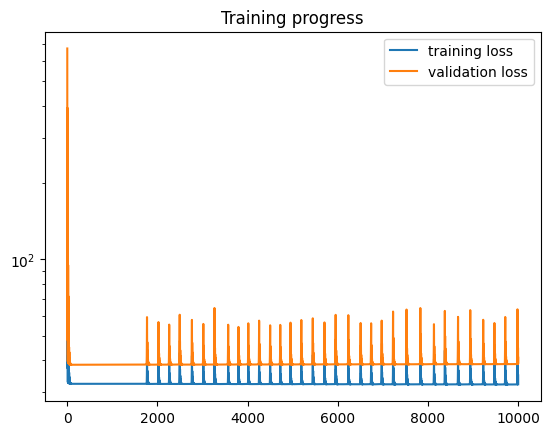

In [13]:
plt.title("Training progress")
plt.yscale("log")
plt.plot(training_loss, label = 'training loss')
plt.plot(validation_loss, label = 'validation loss')
plt.legend()
plt.show()



## Comparer les loss
Ceci donne déjà une idée de l'erreur moyenne de chaque modèle

In [14]:
print('Testing')
print(f'FCNN Loss: {loss_func(best_model(x_test), y_test).item()}')
print(f'Dummy Loss: {loss_func(dummy_predictor(x_test), y_test).item()}')
print(f'Linear Interpolation Loss: {loss_func(interpolation_predictor(x_test), y_test).item()}')
print(f'HWES Loss: {loss_func(hwes_predictor(x_test), y_test).item()}')

Dummy Loss: 75.77690887451172


Sans surprise, HWES et FCNN ont les erreurs les plus faibles.
Il est fort probable que le modèle *dummy* se porte bien également, par rapport à l'interpolation.

## Affichage des prédictions FCNN et HWES

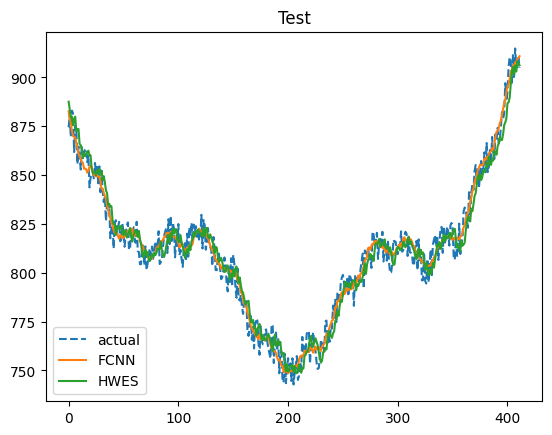

In [15]:
plt.title('Test')
plt.plot(y_test, '--', label = 'actual')
plt.plot(best_model(x_test).tolist(), label = 'FCNN')
plt.plot(hwes_predictor(x_test).tolist(), label = 'HWES')
plt.legend()
plt.show()


avec un petit zoom

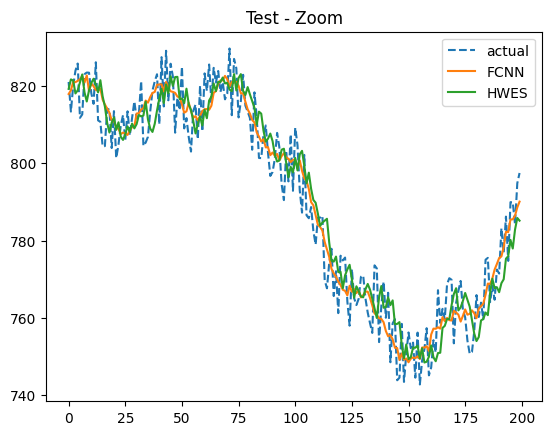

In [16]:
plt.title('Test - Zoom')
plt.plot(y_test[50:250], '--', label = 'actual')
plt.plot(best_model(x_test).tolist()[50:250], label = 'FCNN')
plt.plot(hwes_predictor(x_test).tolist()[50:250], label = 'HWES')
plt.legend()
plt.show()



## Analyse des prédictions : qui gagne ?

Dans ce graphique, on affiche l'erreur de FCN et de HWES pour chaque "entrée" du dataset de test.

Cepenant, on calcule qui a l'erreur (absolute) la plus petite. La fonction `ReLU` "bloque" ceux qui ont l'erreur la plus grande.

Le résultat est qu'on met en **vert** les entrées pour lesquelles le FCNN présente la plus petite erreur, et en **rouge** celles du HWES.

Si vous avez entrainé le FCNN jusqu'à la fin, vous devez voir un peu plus de lignes vertes que rouges.
Si les lignes vertes sont "plus hautes" que les rouges, cela veut dire que les HWES avait une erreur encore plus élevée pour ces entrées. On peut donc imaginer que vert est juste "derrière la course" les fois où rouge gagne.

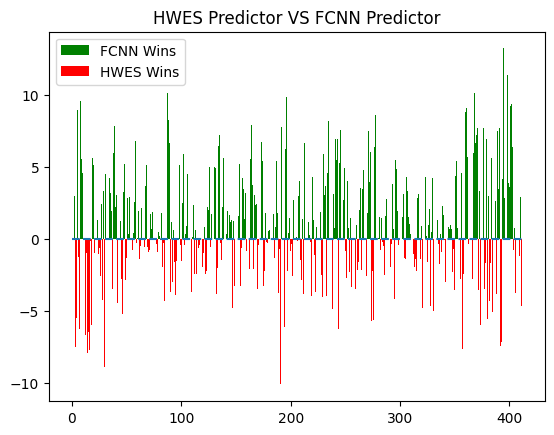

In [17]:
test_n = len(y_test)
net_abs_dev = (best_model(x_test) - y_test).abs_()
hwes_abs_dev = (hwes_predictor(x_test) - y_test).abs_()
diff_pos = F.relu(hwes_abs_dev - net_abs_dev).reshape(test_n).tolist()
diff_min = (-F.relu(net_abs_dev - hwes_abs_dev)).reshape(test_n).tolist()
plt.title('HWES Predictor VS FCNN Predictor')
plt.hlines(0, xmin = 0, xmax = test_n, linestyles = 'dashed')
plt.bar(list(range(test_n)), diff_pos, color = 'g', label = 'FCNN Wins')
plt.bar(list(range(test_n)), diff_min, color = 'r', label = 'HWES Wins')
plt.legend()
plt.show()

## Exercice 2
Modifier le code précédent pour compter combien de fois chaque stratégie gagne.

# Exercice 3

Dans le code précédent, nous n'avons pas utilisé vos dataloaders...
C'est l'heure de les modifier et faire un code pytorch "propre".Rendre votre code sur Moodle

In [11]:


net.train()

optimizer = torch.optim.Adam(params = net.parameters())
loss_func = torch.nn.MSELoss()

best_model = None
min_val_loss = 1_000_000

training_loss = []
validation_loss = []


for epoch in range(10_000):

    net.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = net(xb)
        loss = loss_func(pred, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)
    train_loss_epoch = running_loss / len(train_loader.dataset)


    net.eval()
    with torch.no_grad():
        val_running_loss = 0.0
        for xb, yb in val_loader:
            val_pred = net(xb)
            val_loss = loss_func(val_pred, yb)
            val_running_loss += val_loss.item() * xb.size(0)
        val_loss_epoch = val_running_loss / len(val_loader.dataset)

    training_loss.append(train_loss_epoch)
    validation_loss.append(val_loss_epoch)


    if val_loss_epoch < min_val_loss:
        best_model = copy.deepcopy(net)
        min_val_loss = val_loss_epoch


    if epoch % 1000 == 0:
        print(f"epoch {epoch}: train - {train_loss_epoch:.4f}, val - {val_loss_epoch:.4f}")

net.eval()



epoch 0: train - 38968.3988, val - 19096.8290
epoch 1000: train - 45.6999, val - 81.5005
epoch 2000: train - 45.4965, val - 38.3323
epoch 3000: train - 40.4447, val - 38.5280
epoch 4000: train - 39.2301, val - 41.3126
epoch 5000: train - 34.1255, val - 37.9303
epoch 6000: train - 37.1987, val - 61.7280
epoch 7000: train - 36.6118, val - 39.8506
epoch 8000: train - 38.8482, val - 39.7858
epoch 9000: train - 33.1052, val - 40.6761


FCNN(
  (lin1): Linear(in_features=256, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=32, bias=True)
  (lin3): Linear(in_features=32, out_features=1, bias=True)
)